In [1]:
%matplotlib inline

import time
import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from Models.NVP import NVP

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double moon distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 4 different 'modes'. 

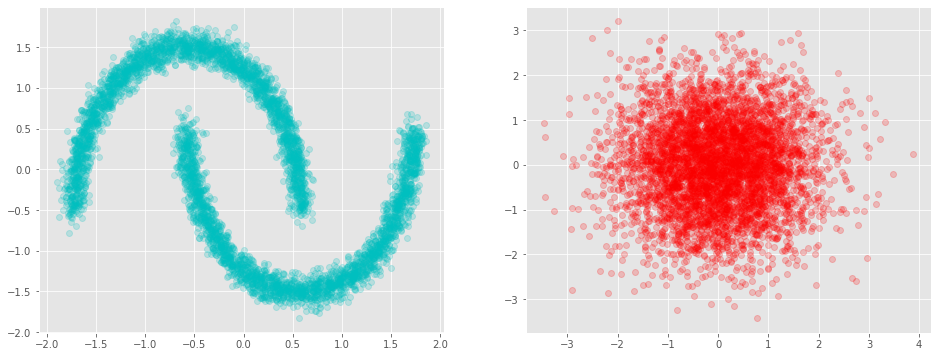

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

X, y = datasets.make_moons(n_samples=num_samples, noise=.05)
X = StandardScaler().fit_transform(X)
target = tf.constant(X,dtype=tf.float32)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object
nvp = NVP(num_layers=9, neuron_list=[150,150])

# Adam optimizer parameters
base_lr = 1e-4
end_lr = 1e-5

# Define training options
n_epochs = 20
batch_size = 25

# Create optimizer and compile nvp with it
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, n_epochs, end_lr, power=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [4]:
# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likelihood: 2.5767
Epoch 2/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likelihood: 2.5230
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likelihood: 2.4987
Epoch 4/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likelihood: 2.4763
Epoch 5/20
200/200 [==============================] - 2s 12ms/step - Negative Log Likelihood: 2.4622
Epoch 6/20
200/200 [==============================] - 2s 12ms/step - Negative Log Likelihood: 2.4543
Epoch 7/20
200/200 [==============================] - 2s 12ms/step - Negative Log Likelihood: 2.4370
Epoch 8/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likelihood: 2.4253
Epoch 9/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likelihood: 2.4097
Epoch 10/20
200/200 [==============================] - 3s 13ms/step - Negative Log Likeliho

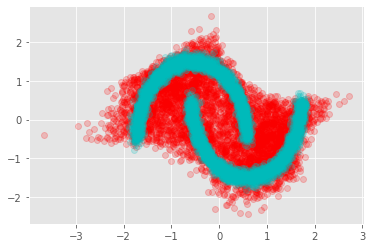

In [5]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

## Conditional Sampling using Metropolis Hastings

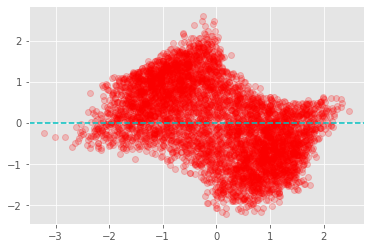

In [9]:
# We want to draw condition samples from about y = 0.0
y_star = 0.0

forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')

In [10]:
# First, we define the function that gives the log prob at a point
def log_c_target(x1, x2 = y_star):
    x = tf.constant([x1,x2],shape=[1,2])
    #log of probability density at that point
    return nvp.flow.log_prob(x)

# Next, the Metropolis hastings algorithm
def MCMC(niters=2000,b=.4,init_val=0.0):
    # niters: number of interations of MCMC
    # b: variance of the proposal Gaussian density for X1
    
    naccept=0
    theta = init_val # initial value for the Markov chain

    samples = np.zeros(niters+1)
    samples[0] = theta
    t0 = time.time()
    for i in range(niters):
        theta_p = theta + np.random.randn()*b;
        rho = min(1, tf.math.exp(log_c_target(theta_p)-log_c_target(theta)))
        u = np.random.uniform()
        if u < rho:
            naccept += 1
            theta = theta_p
        samples[i+1] = theta
        if i % 100 == 0:
            t1 = time.time()
            print('it:',i,'time:',t1-t0)
    acceptance_rate = naccept/niters
    
    return acceptance_rate, samples

In [11]:
x = tf.constant([1.0, 1.0],shape=[1,2])
nvp.flow.log_prob([1.0, 1.0])

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: real_nvp_default_template_8_1/strided_slice_1:0

In [12]:
# Run the algorithm
acc_rate, samples = MCMC()

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: real_nvp_default_template_8_2/split:0